<a href="https://www.kaggle.com/code/dimasjackson/housing-prices-predictions?scriptVersionId=113848270" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Housing Prices Predictions

### Abstract

This notebook is a compilation of the knowledge from Kaggle Machine Learning courses to generate a better submission to the Housing Prices Competition. First of all, the data will be imported from the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course) and preprocessed using different techniques. We will select the best preprocess technique between Ordinal Encoder, One-hot Encoder or simply dropping out categorical data, by comparison of the Mean Absolute Error (MAE) of the predictions generated by each approach. Next, we will create a pipeline to implement the best preprocess more quickly, which will allow us to test different machine learning models. Then, we will compare the MAE of different Random Forest and Gradient Boost models, varying the number of estimators and the learning rate. The model that results in the smallest MAE in validation data will be used to generate predictions using the test data, which will be submited to the competition.

![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)


# Table of Contents

* [Importing the Data](#imp)
* [Exploratory Data Analysis](#exp)
* [Pre-processing the Data](#pre)
* [Creating a Pipeline](#pip)
* [Comparing Different Machine Learning Models](#com)
* [Generating Predictions and Submiting the Results](#gen)

# Importing the Data

The next code cell will load the data from Kaggle data base:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the training and test data
X = pd.read_csv('../input/train.csv', index_col='Id') 
X_test = pd.read_csv('../input/test.csv', index_col='Id')

# Exploratory Data Analysis

Let's take a peek in the first rows of the data set:

In [2]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data fields

Here's a brief version of what you'll find in the data description file.

    SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
    MSSubClass: The building class
    MSZoning: The general zoning classification
    LotFrontage: Linear feet of street connected to property
    LotArea: Lot size in square feet
    Street: Type of road access
    Alley: Type of alley access
    LotShape: General shape of property
    LandContour: Flatness of the property
    Utilities: Type of utilities available
    LotConfig: Lot configuration
    LandSlope: Slope of property
    Neighborhood: Physical locations within Ames city limits
    Condition1: Proximity to main road or railroad
    Condition2: Proximity to main road or railroad (if a second is present)
    BldgType: Type of dwelling
    HouseStyle: Style of dwelling
    OverallQual: Overall material and finish quality
    OverallCond: Overall condition rating
    YearBuilt: Original construction date
    YearRemodAdd: Remodel date
    RoofStyle: Type of roof
    RoofMatl: Roof material
    Exterior1st: Exterior covering on house
    Exterior2nd: Exterior covering on house (if more than one material)
    MasVnrType: Masonry veneer type
    MasVnrArea: Masonry veneer area in square feet
    ExterQual: Exterior material quality
    ExterCond: Present condition of the material on the exterior
    Foundation: Type of foundation
    BsmtQual: Height of the basement
    BsmtCond: General condition of the basement
    BsmtExposure: Walkout or garden level basement walls
    BsmtFinType1: Quality of basement finished area
    BsmtFinSF1: Type 1 finished square feet
    BsmtFinType2: Quality of second finished area (if present)
    BsmtFinSF2: Type 2 finished square feet
    BsmtUnfSF: Unfinished square feet of basement area
    TotalBsmtSF: Total square feet of basement area
    Heating: Type of heating
    HeatingQC: Heating quality and condition
    CentralAir: Central air conditioning
    Electrical: Electrical system
    1stFlrSF: First Floor square feet
    2ndFlrSF: Second floor square feet
    LowQualFinSF: Low quality finished square feet (all floors)
    GrLivArea: Above grade (ground) living area square feet
    BsmtFullBath: Basement full bathrooms
    BsmtHalfBath: Basement half bathrooms
    FullBath: Full bathrooms above grade
    HalfBath: Half baths above grade
    Bedroom: Number of bedrooms above basement level
    Kitchen: Number of kitchens
    KitchenQual: Kitchen quality
    TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    Functional: Home functionality rating
    Fireplaces: Number of fireplaces
    FireplaceQu: Fireplace quality
    GarageType: Garage location
    GarageYrBlt: Year garage was built
    GarageFinish: Interior finish of the garage
    GarageCars: Size of garage in car capacity
    GarageArea: Size of garage in square feet
    GarageQual: Garage quality
    GarageCond: Garage condition
    PavedDrive: Paved driveway
    WoodDeckSF: Wood deck area in square feet
    OpenPorchSF: Open porch area in square feet
    EnclosedPorch: Enclosed porch area in square feet
    3SsnPorch: Three season porch area in square feet
    ScreenPorch: Screen porch area in square feet
    PoolArea: Pool area in square feet
    PoolQC: Pool quality
    Fence: Fence quality
    MiscFeature: Miscellaneous feature not covered in other categories
    MiscVal: Value of miscellaneous feature
    MoSold: Month Sold
    YrSold: Year Sold
    SaleType: Type of sale
    SaleCondition: Condition of sale


In [3]:
X.shape

(1460, 80)

This data set contains information about 1168 houses, described in 79 features of categorical and numerical data. We will investigate relationship between these features, may be some field is correlatad with the target SalePrice

In [4]:
X.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
X.describe()['SalePrice']

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Here we can see that the mean sale price is **USD 180.921,19** with a standard deviation of **USD 79.442,50**.

### Correlation Matrix

In [6]:
# Import Seaborn and Matplotlib to data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
# Chosing the theme style
sns.set_theme(style="white")

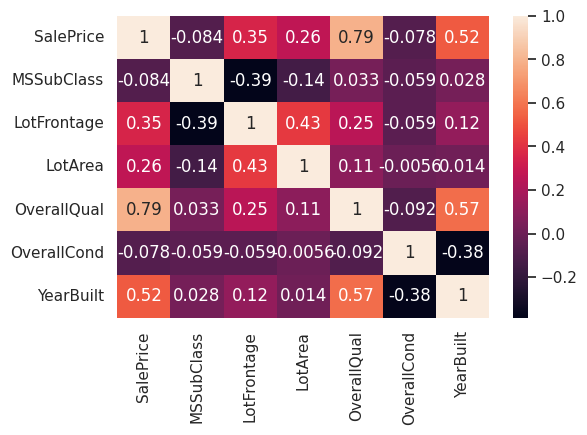

In [7]:
#Correlation matrix

# Selecting only interesting columns
cols = ['SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt']
selected_df = X[cols]

# Defining the correlation matrix using Pearson method
corr_matrix = selected_df.corr()
# Generating a visual output (heatmap)
sns.heatmap(corr_matrix, annot=True)
plt.show()

It is important to note that the lot frontage, the lot area, the overall quality and the year buit are the most correlated numerical variables with the sale price. The `MSSubClass` and the `OverallCond` are weakly correlated with the SalePrice so we will drop these columns.

In [8]:
#Collumns that will be dropped
weak_col = ['MSSubClass', 'OverallCond']
X.drop(weak_col, axis=1, inplace=True)

In [9]:
X.shape

(1460, 78)

We need to split the data into a train and a validaton data set, that will be used to train and validade Machine Learning models. Do not confuse the validation set with the test data set, which will be used to generate predictions that will be submited to the competition. 

In [10]:
# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

Now we will visualize the data and calculate the correlation matrix the to find what features are most relevant to the target.

Text(0, 0.5, 'Sale Price')

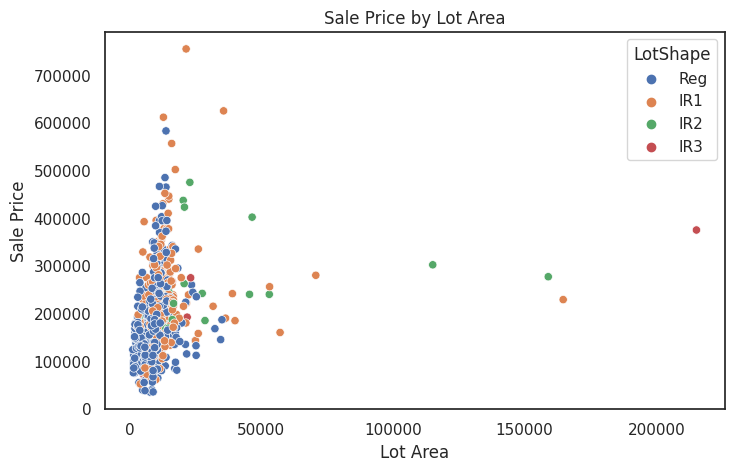

In [11]:
# Plot the lot area by sale price in train set
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_train['LotArea'], y=y_train.values, hue=X_train['LotShape']).set(title="Sale Price by Lot Area")
plt.xlabel("Lot Area")
plt.ylabel("Sale Price")

The colors in figure above indicates the general shape of the propertie, Reg (blue) = Regular, IR1 (orange) = Slightly irregular, IR2 (green) = Moderately Irregular and IR3 (red) = Irregular. We can see that the sale price increases approximately linearly with the lot area for properties with a regular and slightly regular shape. In contrast, the price doesn't increase to much whe the lot is irregular/moderately irregular, even for properties with a big area.  

Text(0, 0.5, 'Sale Price')

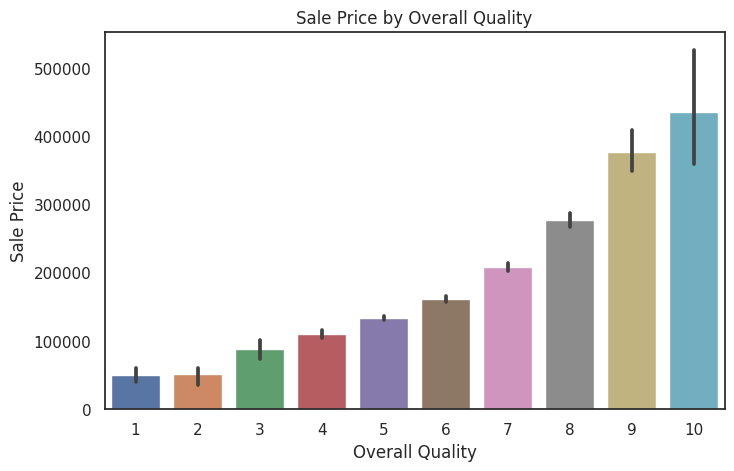

In [12]:
# Plot the sale price by overall quality in train set
plt.figure(figsize=(8,5))
sns.barplot(x=X_train['OverallQual'], y=y_train.values).set(title="Sale Price by Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("Sale Price")

The `OverallQual` rates the overall material and finish of the house, where  10 = Very Excellent, 9 = Excellent, 8 = Very Good, 7 = Good, 6 = Above Average, 5 = Average, 4 = Below Average, 3 = Fair, 2 = Poor, 1 = Very Poor. As predicted by the correlation matrix, the overall quality direct influences the sale price. Houses that were classified with a overall quality 10 was saled for nearly 9 times the price of that with overall quality 1.

Text(0, 0.5, 'Sale Price')

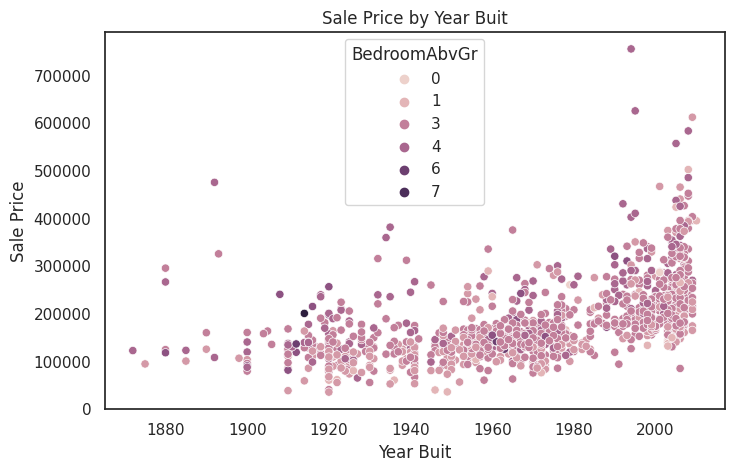

In [13]:
# Plot the lot area by sale price in train set
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_train['YearBuilt'], y=y_train.values, hue=X_train['BedroomAbvGr']).set(title="Sale Price by Year Buit")
plt.xlabel("Year Buit")
plt.ylabel("Sale Price")

The sale price also increase with the year built, specially after 1990's. The number of bedrooms above the basement level doesn't seem to influence much the target. May be discarding this feature improve the score of the predictions.

In [14]:
X_train.drop(['BedroomAbvGr'], axis=1, inplace=True)
X_train.shape

(1168, 76)

In [15]:
X_valid.drop(['BedroomAbvGr'], axis=1, inplace=True)
X_valid.shape

(292, 76)

<a id="pre" ></a>
# Pre-processing the Data

In this section we will pre-process the data filling the missing values and using encoders to change categorical data into numerical one. Then, we will compare the Mean Absolute Error of models trained with data preprocessed in different ways.

## Replacing missing values

Next, we will use `SimpleImputer` to replace missing values with the most frequent value along each column.

In [16]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent') # This strategy replace missing using the most frequent value along each column.

X_train_imp = pd.DataFrame(imputer.fit_transform(X_train))
X_valid_imp = pd.DataFrame(imputer.transform(X_valid))

# Imputation removes the column names, we need to put them back
X_train_imp.columns = X_train.columns
X_valid_imp.columns = X_valid.columns

Simple Imputer turns all column types in objects, it is necessary to change the numerical columns into float or int. 

In [17]:
# Selecting the numerical columns in the original X_train data set
s = (X_train.dtypes != 'object')
num_cols = list(s[s].index)

print(num_cols)

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [18]:
# Converting numerical columns from object to float or int
X_train_imp[num_cols]=X_train_imp[num_cols].apply(pd.to_numeric)
X_valid_imp[num_cols]=X_valid_imp[num_cols].apply(pd.to_numeric)

Now all the missing values in training data are replaced by the most frequent and the numerical columns are restored to its original data type. It is important to note that the missing values are not removed from the validation data, see the info above. Let's deal with the categorical data.

## Encoding Categorical Data

Notice that the dataset contains both numerical and categorical variables.  It is necessary to encode the categorical data before training a model. To compare different models, we'll define the function `score_dataset()`.  This function reports the [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE) from a random forest model.

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0, criterion="absolute_error")
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### Dropping columns with categorical data

The code cell below preprocess the data in `X_train` and `X_valid` to remove columns with categorical data and set the preprocessed DataFrames to `drop_X_train` and `drop_X_valid`, respectively.  

In [20]:
# Printing the data set columns which are objects
s = (X_train_imp.dtypes == 'object')
object_col=list(s[s].index)
print(object_col)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [21]:
# Drop object columns in training and validation data
drop_X_train = X_train_imp.select_dtypes(exclude=['object'])
drop_X_valid = X_valid_imp.select_dtypes(exclude=['object'])
drop_X_train.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,90.0,11694,9,2007,2007,452.0,48,0,1774,1822,...,774,0,108,0,0,260,0,0,7,2007
1,60.0,6600,5,1962,1962,0.0,0,0,894,894,...,308,0,0,0,0,0,0,0,8,2009
2,80.0,13360,5,1921,2006,0.0,713,0,163,876,...,432,0,0,44,0,0,0,0,8,2009
3,60.0,13265,8,2002,2002,148.0,1218,0,350,1568,...,857,150,59,0,0,0,0,0,7,2008
4,118.0,13704,7,2001,2002,150.0,0,0,1541,1541,...,843,468,81,0,0,0,0,0,1,2006


The next code cell gives the Mean Absolute Error for this approach.

In [22]:
print("MAE from Approach 1 (Drop categorical variables):")
mae_1 = score_dataset(drop_X_train, drop_X_valid, y_train, y_valid)
print(mae_1)

MAE from Approach 1 (Drop categorical variables):
18356.972328767122


### Ordinal encoding

We cannot write a code to fit an ordinal encoder to the training data, and then use it to transform both the training and validation data, since the `'Condition2'` column present different values in the training and validation data. The code cell below prints the unique entries of `'Condition2'` column, in both the training and validation sets.

In [23]:
print("Unique values in 'Condition2' column in training data:", X_train['Condition2'].unique())
print("\nUnique values in 'Condition2' column in validation data:", X_valid['Condition2'].unique())

Unique values in 'Condition2' column in training data: ['Norm' 'PosA' 'Feedr' 'PosN' 'Artery' 'RRAe']

Unique values in 'Condition2' column in validation data: ['Norm' 'RRAn' 'RRNn' 'Artery' 'Feedr' 'PosN']


The code cell below saves the problematic columns to a Python list `bad_label_cols`.  Likewise, columns that can be safely ordinal encoded are stored in `good_label_cols`.

In [24]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Condition2', 'MiscFeature', 'RoofMatl', 'Functional']


The next code cell will ordinal encode the data in `X_train` and `X_valid` and set the preprocessed DataFrames to `label_X_train` and `label_X_valid`, respectively.

In [25]:
from sklearn.preprocessing import OrdinalEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train_imp.drop(bad_label_cols, axis=1)
label_X_valid = X_valid_imp.drop(bad_label_cols, axis=1)

# Apply ordinal encoder 
encoder = OrdinalEncoder() # Your code here
label_X_train[good_label_cols] = encoder.fit_transform(X_train_imp[good_label_cols])
label_X_valid[good_label_cols] = encoder.transform(X_valid_imp[good_label_cols])

The next code cell gives the MAE for this approach and allows a comparison between approachs 1 and 2.

In [26]:
print("MAE from approach 1 (Drop categorical variables):")
print(mae_1)
print("MAE from approach 2 (Ordinal Encoding):") 
mae_2 = score_dataset(label_X_train, label_X_valid, y_train, y_valid)
print(mae_2)

MAE from approach 1 (Drop categorical variables):
18356.972328767122
MAE from approach 2 (Ordinal Encoding):
17762.29537671233


**We can seen that encoding categorical data yields better results than removing columns from the dataset.**

### Investigating cardinality

The output below shows the number of unique values in the column for each column with categorical data.  For instance, the `'Street'` column in the training data has two unique values: `'Grvl'` and `'Pave'`, corresponding to a gravel road and a paved road, respectively. We refer to the number of unique entries of a categorical variable as the **cardinality** of that categorical variable.

In [27]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train_imp[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Alley', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('GarageFinish', 3),
 ('PavedDrive', 3),
 ('PoolQC', 3),
 ('MiscFeature', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('MasVnrType', 4),
 ('ExterQual', 4),
 ('BsmtQual', 4),
 ('BsmtCond', 4),
 ('BsmtExposure', 4),
 ('KitchenQual', 4),
 ('Fence', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Electrical', 5),
 ('FireplaceQu', 5),
 ('GarageQual', 5),
 ('GarageCond', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('BsmtFinType1', 6),
 ('BsmtFinType2', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('GarageType', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

For large datasets with many rows, one-hot encoding can greatly expand the size of the dataset.  For this reason, we typically will only one-hot encode columns with relatively low cardinality.  Then, high cardinality columns can either be dropped from the dataset, or we can use ordinal encoding.

Next, we'll only create a one-hot encoding for columns with cardinality less than 10.

In [28]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train_imp[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior2nd', 'Exterior1st', 'Neighborhood']


### One-hot encoding

The next code cell will one-hot encode the data in `X_train` and `X_valid` and set the preprocessed DataFrames to `OH_X_train` and `OH_X_valid`, respectively.

In [29]:
from sklearn.preprocessing import OneHotEncoder

# Use as many lines of code as you need!
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train_imp[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid_imp[low_cardinality_cols]))

OH_cols_train.head()

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
# One-hot encoding removed index; put it back
OH_cols_train.index = X_train_imp.index
OH_cols_valid.index = X_valid_imp.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train_imp.drop(object_cols, axis=1)
num_X_valid = X_valid_imp.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_train.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,181,182,183,184,185,186,187,188,189,190
0,90.0,11694,9,2007,2007,452.0,48,0,1774,1822,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,60.0,6600,5,1962,1962,0.0,0,0,894,894,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,80.0,13360,5,1921,2006,0.0,713,0,163,876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60.0,13265,8,2002,2002,148.0,1218,0,350,1568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,118.0,13704,7,2001,2002,150.0,0,0,1541,1541,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


The next code cell gives the MAE for this approach and remember the MAE from the last approaches.

In [31]:
print("MAE from approach 1 (Drop categorical variables):")
print(mae_1)
print("MAE from approach 2 (Ordinal Encoding):") 
print(mae_2)
mae_3 = score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)
print("MAE from Approach 3 (One-Hot Encoding):") 
print(mae_3)

MAE from approach 1 (Drop categorical variables):
18356.972328767122
MAE from approach 2 (Ordinal Encoding):
17762.29537671233


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


MAE from Approach 3 (One-Hot Encoding):
17840.42976027397


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


**Until now, the Ordinal Encoding provides the smallest Mean Absolute Error in the validation data, so we will implement it in a pipeline.**

<a id="pip" ></a>
# Creating a Pipeline

We will create a pipeline to implement the ordinal encoder in a more compact way. Also, we will use `SimpleImputer` to fill missing values with the most frequent value along each column.

In [32]:
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

# Selecting the columns with cardinality less than 10
categorical_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]

# Selecting numerical columns
numerical_cols = [col_name for col_name in X_train.columns if
                      X_train[col_name].dtype in ['int64','float64']]

In [33]:
# Preprocessing for nummerical data:
num_preprocess = SimpleImputer(strategy='most_frequent') # This strategy replace missing using the most frequent value along each column.

# Preprocessing for categorical data:
cat_preprocess = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('encoder', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_preprocess, numerical_cols),
        ('cat', cat_preprocess, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0, criterion="absolute_error")

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17733.025051369863


<a id="com"></a>
# Comparing Different Machine Learning Models

Using the pipeline, we can compare different machine learning models varing the parameters or even the algorithm. Let's start with the number of estimators:

In [34]:
# Defining four different models increasing the number of estimators
model_1 = RandomForestRegressor(n_estimators=50, random_state=0, criterion="absolute_error")
model_2 = RandomForestRegressor(n_estimators=75, random_state=0, criterion="absolute_error")
model_3 = RandomForestRegressor(n_estimators=100, random_state=0, criterion="absolute_error")
model_4 = RandomForestRegressor(n_estimators=125, random_state=0, criterion="absolute_error")

models = (model_1,model_2,model_3,model_4)

for model in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    print(model,'MAE:', mean_absolute_error(y_valid, preds))

RandomForestRegressor(criterion='absolute_error', n_estimators=50,
                      random_state=0) MAE: 17836.715753424658
RandomForestRegressor(criterion='absolute_error', n_estimators=75,
                      random_state=0) MAE: 17737.15732876712
RandomForestRegressor(criterion='absolute_error', random_state=0) MAE: 17733.025051369863
RandomForestRegressor(criterion='absolute_error', n_estimators=125,
                      random_state=0) MAE: 17640.022068493152


The best result until now is the model with ***125 estimators***. Let's try to increase more:

In [35]:
model_5 = RandomForestRegressor(n_estimators=150, random_state=0, criterion="absolute_error")
model_6 = RandomForestRegressor(n_estimators=200, random_state=0, criterion="absolute_error")
model_7 = RandomForestRegressor(n_estimators=250, random_state=0, criterion="absolute_error")
model_8 = RandomForestRegressor(n_estimators=300, random_state=0, criterion="absolute_error")

models = (model_5,model_6,model_7,model_8)

for model in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    print(model,'MAE:', mean_absolute_error(y_valid, preds))

RandomForestRegressor(criterion='absolute_error', n_estimators=150,
                      random_state=0) MAE: 17571.126495433793
RandomForestRegressor(criterion='absolute_error', n_estimators=200,
                      random_state=0) MAE: 17675.861001712332
RandomForestRegressor(criterion='absolute_error', n_estimators=250,
                      random_state=0) MAE: 17722.18245890411
RandomForestRegressor(criterion='absolute_error', n_estimators=300,
                      random_state=0) MAE: 17748.824423515984


Here we need to be carefull, although a very small number of estimator cause underfitting, a very hight number of estimators cause overfitting, since the model fits well to training data but not to test data. Moreover, a hight number of estimators require a lot of computational power and time to be tested. Then, we will fix the number of estimators as 300 and change the criterion:

In [36]:
model_4 = RandomForestRegressor(n_estimators=300, random_state=0, criterion="absolute_error")
model_5 = RandomForestRegressor(n_estimators=300, random_state=0, criterion="squared_error")
model_6 = RandomForestRegressor(n_estimators=300, random_state=0, criterion="poisson")

models = (model_4,model_5,model_6)

for model in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    print(model,'MAE:', mean_absolute_error(y_valid, preds))

RandomForestRegressor(criterion='absolute_error', n_estimators=300,
                      random_state=0) MAE: 17748.824423515984
RandomForestRegressor(n_estimators=300, random_state=0) MAE: 17390.928173515982
RandomForestRegressor(criterion='poisson', n_estimators=300, random_state=0) MAE: 27555.26035388128


There are no significant difference between `absolute_error` and `squared_error`, the `poisson` criterion gives a worst MAE. Therefore we will keep the `absolute_error` as the criterion for the Random Forest Regressor. Now, its interesting to compare this model with other regressor, for example the Gradient Boost, with can be implemented trough the XGBRegressor algorithm.

In [37]:
from xgboost import XGBRegressor

model_1_XGB = XGBRegressor(random_state=0, n_estimators=300, learning_rate=0.1)
# A small learning rate allow a big number of estimators
model_2_XGB = XGBRegressor(random_state=0, n_estimators=500, learning_rate=0.01)
model_3_XGB = XGBRegressor(random_state=0, n_estimators=1000, learning_rate=0.001)

models = (model_1_XGB,model_2_XGB,model_3_XGB)

for model in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    print(model,'MAE:', mean_absolute_error(y_valid, preds))


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) MAE: 17413.096933861303
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             im

**The model with a lowest MAE we've found is the Gradient Boost with 300 estimators and learning rate 0.1**

The XGBRegressor `early_stopping_round` option offers a way to automatically find the ideal value for n_estimators. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. However, the early stopping cannot be passed through a pipeline, so we will restore the training data and impute/encode again.

In [38]:
# Drop categorical columns that will not be encoded
enco_X_train = X_train.drop(bad_label_cols, axis=1)
enco_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder 
encoder = OrdinalEncoder() 
enco_X_train[good_label_cols] = encoder.fit_transform(X_train[good_label_cols])
enco_X_valid[good_label_cols] = encoder.transform(X_valid[good_label_cols])

In [39]:
#model_4_XGB = XGBRegressor(random_state=0, n_estimators=3000, learning_rate=0.001, early_stopping_round=5)
model_4_XGB = XGBRegressor(random_state=0, n_estimators=10000, learning_rate=0.01, early_stopping_round=5)

model_4_XGB.fit(enco_X_train, y_train, eval_set=[(enco_X_valid,y_valid)], verbose=False)
preds = model_4_XGB.predict(enco_X_valid)
print('model_4_XGB','MAE:', mean_absolute_error(y_valid, preds))

[22:16:43] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


model_4_XGB MAE: 16876.77607288099


**This is the best model we've found!**

<a id="gen" ></a>
# Generating test predictions and submiting the results


It is necessary to apply the ordinal encode to the test data set: 

In [40]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_test[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))

# Drop categorical columns that will not be encoded
enco_X_test = X_test.drop(bad_label_cols, axis=1)
enco_X_train = X_train.drop(bad_label_cols, axis=1)

In [41]:
enco_X_test.shape

(1459, 72)

In [42]:
enco_X_train.shape

(1168, 69)

In [43]:
# To implement the model, the train and test must have the same shape
cols_train = [col for col in enco_X_train.columns]
cols_test = [col for col in enco_X_test.columns]
l = list(set(cols_test) - set(cols_train))
print(l)

['MSSubClass', 'OverallCond', 'BedroomAbvGr']


In [44]:
# Dropping the columns that we reject in the EDA
enco_X_test = enco_X_test.drop(l, axis=1)

In [45]:
enco_X_test.shape

(1459, 69)

In [46]:
# Apply ordinal encoder 
encoder = OrdinalEncoder() 
enco_X_train[good_label_cols] = encoder.fit_transform(X_train[good_label_cols])
enco_X_test[good_label_cols] = encoder.transform(X_test[good_label_cols])

In [47]:
cols_valid = [col for col in enco_X_valid.columns]
l2 = list(set(cols_valid) - set(cols_test))
print(l2)

['Exterior1st', 'KitchenQual', 'SaleType', 'MSZoning', 'Exterior2nd', 'Utilities']


In [48]:
# Dropping the remaining columns of the validation data, to use in early stop round
enco_X_valid = enco_X_valid.drop(l2, axis=1)
enco_X_valid.shape

(292, 66)

In [49]:
l3 = list(set(cols_train) - set(cols_valid))
print(l3)

['Condition2', 'RoofMatl', 'MiscFeature']


In [50]:
enco_X_test = enco_X_test.drop(l3, axis=1)
enco_X_train = enco_X_train.drop(l3, axis=1)

In [51]:
# Generating predicitions from the final model:
final_model = model_4_XGB
final_model.fit(enco_X_train, y_train)
preds_test = final_model.predict(enco_X_test)

[22:18:04] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [52]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)